In [1]:
import numpy as np
import os, sys, datetime, string
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/')

import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits.basemap import Basemap
import netCDF4
import matplotlib as mpl
import save_fig as sF
import createFolder as cF

In [2]:
savefig = 0   # 1 = yes, 0 = no
fig_dir = '../../Figures/Norway_map'
cF.createFolder(fig_dir)
form = 'png'

In [3]:
def Lambert_map(lllon, lllat, urlon, urlat, lat0, lon0, res='l', fill=False, zoom=False):
    """lllon - lon lower left corner ...
    lat0 - latitude standard parallel, should be somewhere in the center of the domain
    lon0 - the parallel longitude
    lllon - lower left longitude ...
    http://matplotlib.org/basemap/api/basemap_api.html"""
    rsphere=(6378137.00,6356752.3142)
    map = Basemap(llcrnrlon=lllon, llcrnrlat=lllat, urcrnrlon=urlon, urcrnrlat=urlat, rsphere=rsphere,
            resolution=res,area_thresh=1000.,projection='lcc', lat_0=lat0,lon_0=lon0)
#    map = Basemap(llcrnrlon=lllon, llcrnrlat=lllat, urcrnrlon=urlon, urcrnrlat=urlat, rsphere=rsphere,
 #           resolution=res,area_thresh=1000.,projection='lcc', lat_1=lllon,lon_0=lon0)
    # Draw the latitudes and the longitudes
#    parallels = np.arange(0.,90,5.)
 #   map.drawparallels(parallels,labels=[True,False,False,False],fontsize=16)    
  #  meridians = np.arange(10.,361.,10.)
   # map.drawmeridians(meridians,labels=[False,False,False,True],fontsize=16)
    if zoom == False:
        map.drawmeridians(np.arange(0,90,10),labels=[0,0,0,1],fontsize=16)
        map.drawparallels(np.arange(10,361,4),labels=[1,0,0,0],fontsize=16)
    else:
        map.drawmeridians(np.arange(0,90,3),labels=[0,0,0,1],fontsize=16)
        map.drawparallels(np.arange(0,361,2),labels=[1,0,0,0],fontsize=16)

    # Draw the coastline
    map.drawcoastlines()#color='0.5')
    
    

    if fill:
        map.drawlsmask(#land_color='0.8', 
            ocean_color='gainsboro')
    
    if zoom == False:
    
    ### plot MEPS area
        for i in range(0,lato.shape[0],12):
            xs, ys = map(lono[i], lato[i])
            map.plot(xs,ys, color = 'orange', marker = 'o', markersize = 10, linestyle = '-', linewidth = 10)
        for i in range(0,lato2.shape[0],12):
            xs2, ys2 = map(lono2[i], lato2[i])
            map.plot(xs2,ys2, color = 'orange', marker = 'o', markersize = 10, linestyle = '-', linewidth = 10)

        xs, ys = map(lono[739], lato[739])
        map.plot(xs,ys, color = 'orange', marker ='o', markersize = 10, linestyle = '-', linewidth = 10, label = 'MEPS domain')
        lgd = plt.legend(loc='lower left',fontsize=18)

    #map.drawmapboundary(fill_color='gainsboro')
        
    return map    


In [4]:
def PlotContours(Lon, Lat, psurf, map, nrlevels=10, leveldist=None,levels=None, numbers=True, color= 'k'):
    """ contours for example the pressure
    nrlevels - gives the number of displayed levels
    leveldist - gives distance between levels, if specified the nlevels is ignored
    levels - can be an array that specifies the levels to display, if specified nrlevels and leveldist are ignored
    numbers - True if the contours are labeled
    color - color of the contours (None is s color map)"""
    if levels is not None:
        cs= map.contour(Lon, Lat, psurf, levels, linewidths= 1. , colors= color)
    elif leveldist is not None:
        levels= np.arange(np.round(np.min(psurf)- np.min(psurf)%leveldist), np.round(np.max(psurf)+ leveldist), leveldist)
        cs= map.contour(Lon, Lat, psurf, levels, linewidths= 1. , colors= color)        
    else:
        cs= map.contour(Lon, Lat, psurf, nrlevels, linewidths= 1. , colors= color)#, colors= 6*['b']+ 6*['r'],)
    if numbers == True: plt.clabel(cs, fontsize=10, inline=1, fmt='%1.0f', color= 'black')
    #plt.tight_layout()

In [5]:
def PlotColorMap4(Lon, Lat, data, map, maxlevel= None, symetric=True, bounds=None, label='', color= 'RdBu', boxnr= 21):
    """ plot a color map, e.g. vertical velocity
    if symetric == True it is symetric around 0 and the maxlevel is calculated automatically
    best version of PlotColorMap"""
    
    if color== 'RdBu': colors= [(plt.cm.RdBu_r(h)) for h in range(256)]
    elif color== 'seismic': colors= [(plt.cm.seismic(h)) for h in range(256)]
    elif color== 'blue': colors= [(plt.cm.Blues(h)) for h in range(256)]
    elif color== 'inverse_blue': colors= [(plt.cm.Blues(h)) for h in range(255, 0, -1)]

    elif color == 'red': colors= ['azure']+[(plt.cm.Reds(h)) for h in range(256)]
    else: print('wrong color')
#    if bounds != None: boxnr = len(bounds)
    new_map = plt.matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors) #, N=boxnr)

    if bounds is None:
        if maxlevel is not None: minlevel= maxlevel
        if maxlevel is None and bounds is None:
            if symetric is True:
                maxlevel, minlevel= np.max(np.abs(data)), -np.max(np.abs(data))
            else:
                maxlevel, minlevel= np.max(data), np.min(data)       
        
        bounds= np.round(np.linspace(minlevel, maxlevel, boxnr+1), int(np.log10(85/maxlevel)))
#        bounds= np.round(list(np.linspace(-maxlevel, 0, boxnr//2+1))+list(np.linspace(0, maxlevel, boxnr//2+1)), int(np.log10(85/maxlevel)))        
#        print(maxlevel)

    Lon= 0.5* (Lon[1:, 1:]+ Lon[:-1, :-1])
    Lat= 0.5* (Lat[1:, 1:]+ Lat[:-1, :-1])
        
    norm= mpl.colors.BoundaryNorm(bounds, new_map.N)
    cs= map.pcolormesh(Lon, Lat, data[1:, 1:], norm= norm, cmap=new_map, alpha= 1.)
    cb = map.colorbar(cs, boundaries= bounds, norm= norm, location='right',pad='3%',extend='max')
        
    cb.set_label(label, size=18)    
    cb.ax.tick_params(labelsize=16)


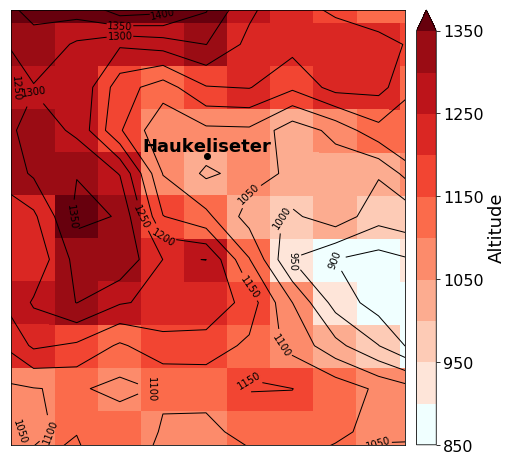

In [6]:
url = ('http://thredds.met.no/thredds/dodsC/meps25epsarchive/2016/12/24/meps_mbr0_pp_2_5km_20161224T12Z.nc')
dataset = netCDF4.Dataset(url)

land= dataset.variables['land_area_fraction'][:]
lonpp= dataset.variables['longitude'][:]
latpp= dataset.variables['latitude'][:]
        
#T_2m= dataset.variables['air_temperature_2m'][:]
alti= dataset.variables['altitude'][:]


dataset.close()



""" altitude map"""
#plt.figure(1)
fig = plt.figure(figsize=(9,8))
plt.clf()
map= Lambert_map(lllon=7.05, lllat=59.65, urlon=7.4, urlat=59.9, lat0= 63.5, lon0= 15, res='i', fill=False,zoom=True)


Lonpp,Latpp = map(lonpp,latpp)




#alti[land < 0.5] = 0
#levels = [1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] 
levels = [850, 900,950,1000,1050,1100,1150, 1200, 1250, 1300,1350,1400]#,1450,1500,1550,1600] 

PlotContours(Lonpp, Latpp, alti, map, leveldist=None,levels=levels, numbers=True, color= 'k')

PlotColorMap4(Lonpp, Latpp, alti, map, bounds= levels,color='red', label='Altitude')

namestat = ['Haukeliseter']#, 'GP']
lonstat = [7+12.87/60]#,7.2]
latstat= [59+48.73/60]#,59.8]


xpt, ypt= map(lonstat, latstat)
map.plot(xpt,ypt,'ko')

for i in range(len(namestat)):
    plt.text(xpt[i], ypt[i], namestat[i], fontsize=18,fontweight='bold', ha='center',va='bottom',color='black')

fig_name = 'MEPS_elevation_Haukeli.png'
if savefig == 1:
    sF.save_figure_portrait(fig_dir,fig_name,form)
else:
    plt.show()
plt.close()

/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/matplotlib/colors.py:1221: RuntimeWarning: invalid value encountered in greater_equal
  iret[xx >= b] = i
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/matplotlib/colors.py:1225: RuntimeWarning: invalid value encountered in less
  iret[xx < self.vmin] = -1
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/matplotlib/colors.py:1226: RuntimeWarning: invalid value encountered in greater_equal
  iret[xx >= self.vmax] = max_col


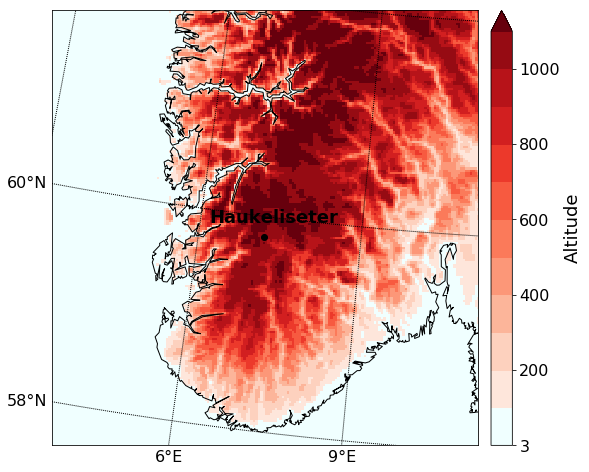

In [7]:
#plt.figure(1)
fig = plt.figure(figsize=(9,8))
#plt.clf()
map = Lambert_map(lllon=4., lllat=57.6, urlon=10.9, urlat=62.1, lat0= 63.5, lon0= 15, res='i', fill=True,zoom=True)
Lonpp,Latpp = map(lonpp,latpp)
alti[alti<3] = np.nan
#PlotContours(Lonpp, Latpp, alti, map, leveldist=None,levels=[0, 25, 50, 100, 200, 300, 400, 500, 600,1000,1500,2000], numbers=True, color= 'k')
PlotColorMap4(Lonpp, Latpp, alti, map, bounds= [3, 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1250, 1500,],color='red', label='Altitude')
#map.drawmapboundary(fill_color='gainsboro')
#map.drawmeridians(np.arange(0,90,10),labels=[0,0,0,1],fontsize=16)
#map.drawparallels(np.arange(0,361.,4),labels=[1,0,0,0],fontsize=16)
namestat = ['Haukeliseter']
lonstat = [7+12.87/60]#,7.2]
latstat= [59+48.73/60]#,59.8]


xpt, ypt= map(lonstat, latstat)
map.plot(xpt,ypt,'ko')
for i in range(len(namestat)):
    plt.text(xpt[i]+10000, ypt[i]+10000, namestat[i], fontsize=18,fontweight='bold', 
             ha='center',va='bottom',color='black')

fig_name = 'South_Norway_MEPS.png'
if savefig == 1:
    sF.save_figure_portrait(fig_dir,fig_name,form)
else:
    plt.show()
plt.close()

In [8]:
lato = np.concatenate((latpp[0,:],latpp[-1,:]), axis = 0)
lono = np.concatenate((lonpp[0,:], lonpp[-1,:]), axis = 0)

lato2 = np.concatenate((latpp[:,0],latpp[:,-1]), axis = 0)
lono2 = np.concatenate((lonpp[:,0], lonpp[:,-1]), axis = 0)

/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/matplotlib/colors.py:1221: RuntimeWarning: invalid value encountered in greater_equal
  iret[xx >= b] = i
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/matplotlib/colors.py:1225: RuntimeWarning: invalid value encountered in less
  iret[xx < self.vmin] = -1
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/matplotlib/colors.py:1226: RuntimeWarning: invalid value encountered in greater_equal
  iret[xx >= self.vmax] = max_col


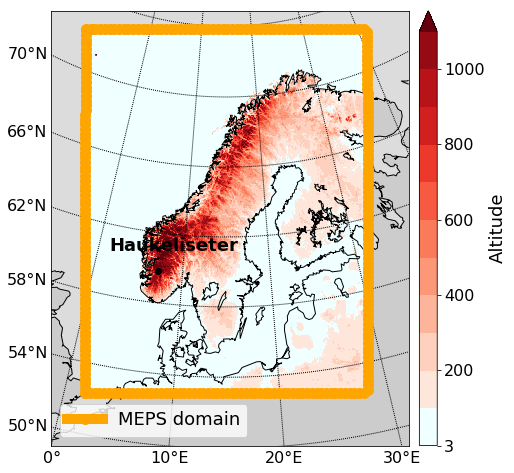

In [9]:
#plt.figure(1)
fig = plt.figure(figsize=(9,8))
#plt.clf()
map = Lambert_map(lllon=0., lllat=49., urlon=50., urlat=72, lat0= 63.5, lon0= 15, res='l', fill=True,zoom=False)
Lonpp,Latpp = map(lonpp,latpp)
alti[alti<3] = np.nan
#PlotContours(Lonpp, Latpp, alti, map, leveldist=None,levels=[0, 25, 50, 100, 200, 300, 400, 500, 600,1000,1500,2000], numbers=True, color= 'k')
PlotColorMap4(Lonpp, Latpp, alti, map, bounds= [3, 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1250, 1500,],color='red', label='Altitude')

namestat = ['Haukeliseter']
lonstat = [7+12.87/60]#,7.2]
latstat= [59+48.73/60]#,59.8]


xpt, ypt= map(lonstat, latstat)
map.plot(xpt,ypt,'ko')
for i in range(len(namestat)):
    plt.text(xpt[i]+100000, ypt[i]+100000, namestat[i], fontsize=18,fontweight='bold', 
             ha='center',va='bottom',color='black')
    

fig_name = 'Norway_elevation_MEPS.png'
if savefig == 1:
    sF.save_figure_portrait(fig_dir,fig_name,form)
else:
    plt.show()
    
plt.close()